In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import mlflow
import mlflow.pytorch
import wandb
import os
from dotenv import load_dotenv
from pathlib import Path

# Import comprehensive logging utilities (now all in one file)
from logging_utils import *

In [2]:
import ale_py
gym.register_envs(ale_py)

In [3]:
class ConvDQN(nn.Module):
    def __init__(self, input_channels, action_size):
        super(ConvDQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Calculate correct feature size dynamically
        self.feature_size = self._get_conv_output_size()
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
    
    def _get_conv_output_size(self):
        """Calculate the output size of conv layers"""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 84, 84)  # 1 batch size, 2 channels, 84x84
            conv_output = self.conv(dummy_input)
            return conv_output.numel() // conv_output.size(0)  # Flatten size per sample
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), action, reward, np.array(next_state), done
    
    def __len__(self):
        return len(self.buffer)

def preprocess_frame(frame):
    import cv2
    gray = np.mean(frame, axis=2).astype(np.uint8)
    cropped = gray[34:194, :]
    resized = cv2.resize(cropped, (84, 84), interpolation=cv2.INTER_AREA)
    return resized.astype(np.float32) / 255.0

class FrameStack:
    def __init__(self, num_frames=2):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
    
    def reset(self, frame):
        processed_frame = preprocess_frame(frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return self.get_stacked()
    
    def step(self, frame):
        processed_frame = preprocess_frame(frame)
        self.frames.append(processed_frame)
        return self.get_stacked()
    
    def get_stacked(self):
        return np.stack(list(self.frames), axis=0)

In [ ]:
# Global hyperparameters with improved training stability
LEARNING_RATE = 0.0001  # Lower learning rate for more stable training
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995  # Same as pong v2
BATCH_SIZE = 32
BUFFER_SIZE = 100000
TARGET_UPDATE = 500  # More frequent target updates for stability
MEAN_REWARD_BOUND = 15000  # Using mean reward bound like pong v1
FRAME_SKIP = 4
INPUT_CHANNELS = 2
FRAME_STACK = 2

# Adaptive training parameters
CONVERGENCE_THRESHOLD = 10000  # When to start adaptive epsilon decay
ADAPTIVE_EPSILON_DECAY = 0.999  # Faster decay when close to convergence

# Unified logging frequency - Enhanced monitoring configuration
LOG_FREQ = 100  # Log comprehensive analysis every 100 episodes
GRADIENT_LOG_FREQ = 500  # Log gradients every 500 steps

# Architecture and logging configuration
ARCHITECTURE_NAME = "CNN-DQN-Defender"
ARCHITECTURE_TYPE = "original"  # "original" for 32-64-64 architecture
MODEL_FILTERS = "32-64-64"

# Setup hyperparameters dictionary - SINGLE SOURCE OF TRUTH
HYPERPARAMETERS = {
    "learning_rate": LEARNING_RATE,
    "gamma": GAMMA,
    "epsilon_start": EPSILON_START,
    "epsilon_min": EPSILON_MIN,
    "epsilon_decay": EPSILON_DECAY,
    "adaptive_epsilon_decay": ADAPTIVE_EPSILON_DECAY,
    "convergence_threshold": CONVERGENCE_THRESHOLD,
    "batch_size": BATCH_SIZE,
    "buffer_size": BUFFER_SIZE,
    "target_update": TARGET_UPDATE,
    "mean_reward_bound": MEAN_REWARD_BOUND,
    "frame_skip": FRAME_SKIP,
    "input_channels": INPUT_CHANNELS,
    "frame_stack": FRAME_STACK,
    "architecture": ARCHITECTURE_NAME,
    "model_filters": MODEL_FILTERS,
    "architecture_type": ARCHITECTURE_TYPE,
    "game": "Defender",
    # Enhanced logging configuration
    "log_freq": LOG_FREQ,
    "gradient_log_freq": GRADIENT_LOG_FREQ,
    "comprehensive_monitoring": True,
    "weight_bias_analysis": True
}

# Set up directories for artifacts using relative paths
RL_STUDY_DIR = Path(__file__).resolve().parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
MLFLOW_TRACKING_URI = RL_STUDY_DIR / 'mlruns'
WANDB_DIR = RL_STUDY_DIR / 'wandb'
BASE_ARTIFACTS_DIR = RL_STUDY_DIR / 'artifacts'

# Configure MLflow to use local tracking
mlflow.set_tracking_uri(f'file://{MLFLOW_TRACKING_URI}')

# Configure wandb to use local directory
os.environ['WANDB_DIR'] = str(WANDB_DIR)
WANDB_DIR.mkdir(exist_ok=True)
BASE_ARTIFACTS_DIR.mkdir(exist_ok=True)
MLFLOW_TRACKING_URI.mkdir(exist_ok=True)

# Initialize wandb with unified project structure
load_dotenv(RL_STUDY_DIR / '.env')
wandb_key = os.getenv('WANDB_KEY')
wandb.login(key=wandb_key)

wandb.init(
    project="defender_dqn_training",  # Separate project for Defender
    name="defender_cnn_dqn_v1",
    dir=str(WANDB_DIR),
    config=HYPERPARAMETERS  # Use single source of truth
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/bmartins/.netrc
wandb: Currently logged in as: bmartins to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Tried to log to step 0 that is less than the current step 4502. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 6502. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 8502. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 11002. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 13502. Steps must be monotonically increasing, so this data will be ignored. See https

In [5]:
# All logging functions are now imported from logging_utils.py

In [6]:
def train_dqn():
    # End any active runs first
    if mlflow.active_run():
        mlflow.end_run()
    
    # MLflow experiment setup - unified with wandb name
    mlflow.set_experiment("defender_dqn_training")
    
    with mlflow.start_run():
        # Create artifacts directory using MLflow run ID and rl_study structure
        run_id = mlflow.active_run().info.run_id
        artifacts_dir = BASE_ARTIFACTS_DIR / f"run_{run_id}"
        artifacts_dir.mkdir(parents=True, exist_ok=True)
        print(f"Artifacts will be saved to: {artifacts_dir}")
        
        env = gym.make('DefenderNoFrameskip-v4')  # Defender game
        
        # Use global hyperparameters
        action_size = env.action_space.n
        lr = LEARNING_RATE
        gamma = GAMMA
        epsilon = EPSILON_START
        epsilon_min = EPSILON_MIN
        epsilon_decay = EPSILON_DECAY
        adaptive_epsilon_decay = ADAPTIVE_EPSILON_DECAY
        convergence_threshold = CONVERGENCE_THRESHOLD
        batch_size = BATCH_SIZE
        buffer_size = BUFFER_SIZE
        target_update = TARGET_UPDATE
        mean_reward_bound = MEAN_REWARD_BOUND  # Using mean reward bound
        frame_skip = FRAME_SKIP
        
        # Log hyperparameters using external function
        log_hyperparameters(str(artifacts_dir), HYPERPARAMETERS)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device = torch.device("cuda")
        print(f"Using device: {device}")
        
        main_net = ConvDQN(input_channels=INPUT_CHANNELS, action_size=action_size).to(device)
        target_net = ConvDQN(input_channels=INPUT_CHANNELS, action_size=action_size).to(device)
        target_net.load_state_dict(main_net.state_dict())
        
        # Setup enhanced weight tracking using logging utils
        setup_weight_tracking(main_net, log_freq=GRADIENT_LOG_FREQ, log_all=True)
        
        # Log model info using external function
        total_params = log_model_info(main_net, device, ARCHITECTURE_NAME)
        
        optimizer = optim.Adam(main_net.parameters(), lr=lr)
        
        # Add learning rate scheduler for stability
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.8)
        
        buffer = ReplayBuffer(buffer_size)
        
        episode_rewards = []
        mean_rewards = []
        episode = 0
        total_steps = 0
        
        while True:
            state, _ = env.reset()
            frame_stack = FrameStack(FRAME_STACK)
            stacked_state = frame_stack.reset(state)
            total_reward = 0
            done = False
            step_count = 0
            episode_losses = []
            
            while not done:
                if random.random() > epsilon:
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(stacked_state).unsqueeze(0).to(device)
                        q_values = main_net(state_tensor)
                        action = q_values.max(1)[1].item()
                else:
                    action = env.action_space.sample()
                
                step_reward = 0
                for _ in range(frame_skip):
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    step_reward += reward
                    if terminated or truncated:
                        break
                
                done = terminated or truncated
                next_stacked_state = frame_stack.step(next_state)
                
                buffer.push(stacked_state, action, step_reward, next_stacked_state, done)
                stacked_state = next_stacked_state
                total_reward += step_reward
                step_count += 1
                total_steps += 1
                
                if len(buffer) > batch_size:
                    states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                    
                    states = torch.FloatTensor(states).to(device)
                    actions = torch.LongTensor(actions).to(device)
                    rewards = torch.FloatTensor(rewards).to(device)
                    next_states = torch.FloatTensor(next_states).to(device)
                    dones = torch.BoolTensor(dones).to(device)
                    
                    current_q_values = main_net(states).gather(1, actions.unsqueeze(1))
                    
                    with torch.no_grad():
                        next_q_values = target_net(next_states).max(1)[0]
                        target_q_values = rewards + (gamma * next_q_values * ~dones)
                    
                    loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
                    episode_losses.append(loss.item())
                    
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(main_net.parameters(), max_norm=10)
                    optimizer.step()
                    
                    # Enhanced gradient logging
                    if total_steps % GRADIENT_LOG_FREQ == 0:
                        log_training_step(loss.item(), episode, step_count)
                        log_layer_wise_gradient_norms(main_net, total_steps)
                        
                        # Log weight and bias norms during training
                        current_weight_norms = {}
                        current_bias_norms = {}
                        for name, param in main_net.named_parameters():
                            if param.requires_grad:
                                if 'bias' in name:
                                    current_bias_norms[f"bias_norms/{name}"] = param.data.norm().item()
                                else:
                                    current_weight_norms[f"weight_norms/{name}"] = param.data.norm().item()
                        
                        wandb.log({
                            **current_weight_norms,
                            **current_bias_norms,
                            "training/total_steps": total_steps,
                            "training/episode": episode,
                            "training/learning_rate": scheduler.get_last_lr()[0]
                        })
                
            # Update target network more frequently for stability
            if episode % target_update == 0:
                target_net.load_state_dict(main_net.state_dict())
            
            # Step learning rate scheduler
            if episode % 100 == 0:
                scheduler.step()
            
            # Adaptive epsilon decay - decay faster when close to convergence
            if epsilon > epsilon_min:
                mean_reward_current = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards) if episode_rewards else 0
                
                if mean_reward_current > convergence_threshold:
                    # Use faster decay when close to convergence
                    epsilon *= adaptive_epsilon_decay
                    wandb.log({"training/adaptive_mode": 1})
                else:
                    # Use normal decay otherwise
                    epsilon *= epsilon_decay
                    wandb.log({"training/adaptive_mode": 0})

            episode_rewards.append(total_reward)
            mean_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            
            # Log episode metrics with loss information
            episode_loss_avg = np.mean(episode_losses) if episode_losses else 0.0
            log_episode_metrics(total_reward, mean_reward, epsilon, len(buffer), step_count, episode)
            wandb.log({
                "episode/avg_loss": episode_loss_avg,
                "episode/num_training_steps": len(episode_losses)
            })
            
            # Basic weight logging every LOG_FREQ episodes
            if episode % LOG_FREQ == 0 and episode > 0:
                log_weight_stats(model=main_net, episode=episode)
            
            # Check stopping condition: mean reward instead of max reward
            if mean_reward >= mean_reward_bound:
                max_reward_so_far = max(episode_rewards) if episode_rewards else 0
                print(f"Environment solved in {episode} episodes! Mean reward: {mean_reward:.2f} >= {mean_reward_bound}")
                print(f"Max reward achieved: {max_reward_so_far:.2f}")
                log_solved_episode(episode)
                break
            
            # Save training plot every 1000 episodes
            if episode > 0 and episode % 1000 == 0:
                save_training_plot(str(artifacts_dir), episode_rewards, episode, mean_reward_bound, " Defender")
            
            # Display plot every 100 episodes
            if episode % 100 == 0 and episode > 0:
                avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
                max_reward_so_far = max(episode_rewards) if episode_rewards else 0
                mean_rewards.append(avg_reward)
                print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Mean Reward (100): {mean_reward:.2f}, Max Reward: {max_reward_so_far:.2f}, Epsilon: {epsilon:.3f}, LR: {scheduler.get_last_lr()[0]:.6f}, Buffer: {len(buffer)}, Total Steps: {total_steps}")
                
                display_training_plot(episode_rewards, mean_reward_bound, " Defender")
            
            # Print progress every 10 episodes
            elif episode % 10 == 0 and episode > 0:
                avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
                max_reward_so_far = max(episode_rewards) if episode_rewards else 0
                print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Mean Reward (100): {mean_reward:.2f}, Max Reward: {max_reward_so_far:.2f}, Epsilon: {epsilon:.3f}, LR: {scheduler.get_last_lr()[0]:.6f}, Buffer: {len(buffer)}, Total Steps: {total_steps}")
                
                log_10_episode_average(avg_reward, episode)

            # Save checkpoint every 10000 episodes
            if episode % 10000 == 0:
                save_checkpoint(str(artifacts_dir), episode, main_net, optimizer, episode_rewards, epsilon, run_id, "defender_dqn_cnn_v1")

            episode += 1
        
        # Log final results
        final_model_path = log_final_results(main_net, episode, mean_reward, episode_rewards, str(artifacts_dir), run_id, "final_defender_dqn_cnn_v1")
        
        print(f"Training completed! All artifacts saved in: {artifacts_dir}")
        print(f"Total steps taken: {total_steps}")
        
        env.close()
        wandb.finish()
        return main_net

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Original frame shape: (210, 160, 3)
Processed frame shape: (84, 84)
Stacked frames shape: (2, 84, 84)
Network input shape: torch.Size([1, 2, 84, 84])
Q-values shape: torch.Size([1, 18])
Action space size (Defender): 18
Q-values: [[-0.01576721  0.01173328  0.04071931 -0.00188102  0.0262433   0.00877373
   0.0188248   0.03489663 -0.02116561  0.01252201  0.01557202  0.00210328
  -0.03228632  0.00050445  0.00773073 -0.01337187  0.04042247  0.0079929 ]]

Total parameters: 3,360,434


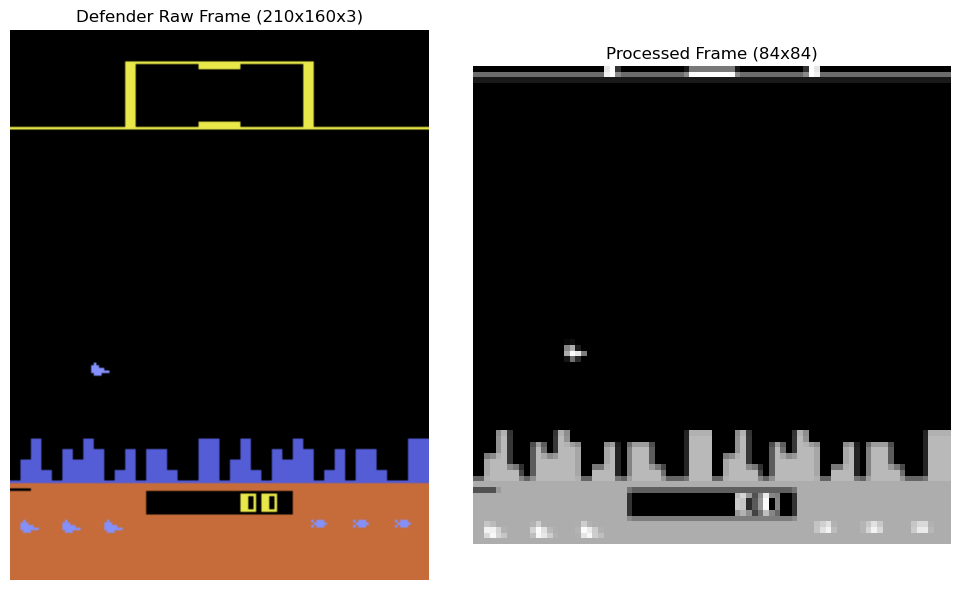

In [7]:
# Test CNN architecture with Defender
env = gym.make('DefenderNoFrameskip-v4')  # Defender game
state, _ = env.reset()

print(f"Original frame shape: {state.shape}")

processed = preprocess_frame(state)
print(f"Processed frame shape: {processed.shape}")

frame_stack = FrameStack(2)
stacked = frame_stack.reset(state)
print(f"Stacked frames shape: {stacked.shape}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_net = ConvDQN(input_channels=2, action_size=env.action_space.n).to(device)

with torch.no_grad():
    state_tensor = torch.FloatTensor(stacked).unsqueeze(0).to(device)
    q_values = cnn_net(state_tensor)
    print(f"Network input shape: {state_tensor.shape}")
    print(f"Q-values shape: {q_values.shape}")
    print(f"Action space size (Defender): {env.action_space.n}")
    print(f"Q-values: {q_values.cpu().numpy()}")

total_params = sum(p.numel() for p in cnn_net.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Show a sample frame to see visual complexity
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(state)
plt.title('Defender Raw Frame (210x160x3)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed, cmap='gray')
plt.title('Processed Frame (84x84)')
plt.axis('off')
plt.tight_layout()
plt.show()

env.close()

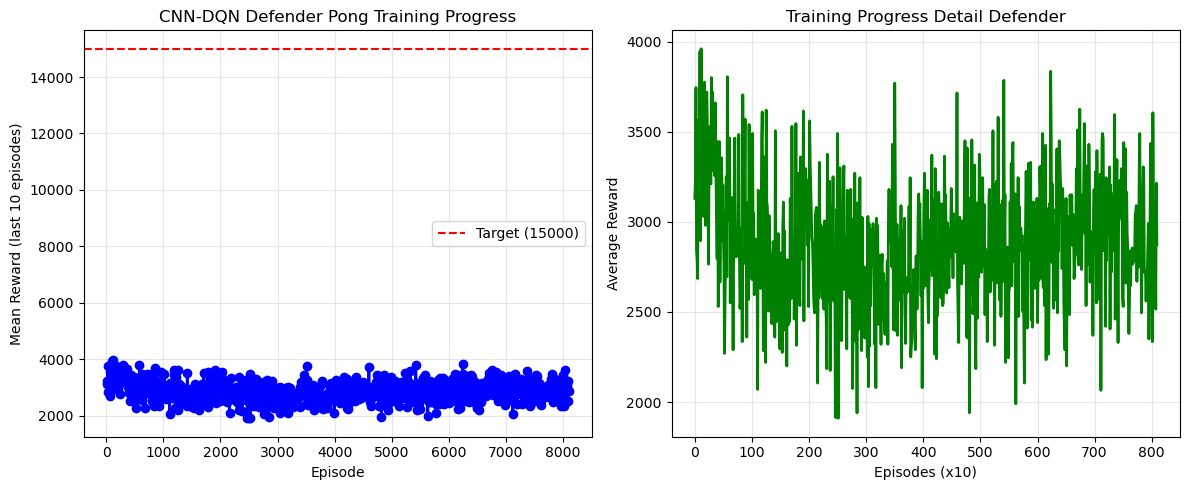

Episode 8110, Avg Reward: 3315.00, Mean Reward (100): 2984.00, Max Reward: 9250.00, Epsilon: 0.010, LR: 0.000100, Buffer: 100000, Total Steps: 8396555
Episode 8120, Avg Reward: 3310.00, Mean Reward (100): 3061.50, Max Reward: 9250.00, Epsilon: 0.010, LR: 0.000100, Buffer: 100000, Total Steps: 8407300


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7bc21e5aa930>> (for post_run_cell), with arguments args (<ExecutionResult object at 7bc1fc038500, execution_count=8 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7bc1fc03a120, raw_cell="# Ensure no active MLflow runs before training
if .." transformed_cell="# Ensure no active MLflow runs before training
if .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/bmartins/dev/rl_study/src/defender_dqn_cnn/defender_dqn_cnn.ipynb#X10sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [8]:
# Ensure no active MLflow runs before training
if mlflow.active_run():
    print("Ending active MLflow run...")
    mlflow.end_run()

# Train the CNN-based DQN on Defender
trained_model = train_dqn()
print("Defender CNN-DQN Training completed!")